In [206]:
import torch 
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 

import onnx
import onnxruntime as ort

import shutil
import sys 
import os 

In [207]:
# Generate input data
x = torch.tensor(np.linspace(-5, 5, 1000), dtype=torch.float)
x = torch.unsqueeze(x, dim=1)

y = x.sin()

In [208]:
# train and save sample 
def save_sample_and_model(case_no, net, x, y):
    
    """
    - the case_no is an int for the model no 
    - function can take value sin, cos, tan, exp, --- >> let it be sine only 
    - x and y are torch tensors; convert to numpy 
    """
    
    print("---- model passed")
    print(net)
    print("-----------------")
        
    x = x.numpy()
    y = y.numpy()
    
    fileName = "model_" + str(0) + str(case_no)  
    
    # Generate 20 random samples
    num_samples = 20
    random_indices = np.random.choice( len(x), num_samples, replace=False)
    
    x_samples = x[random_indices]
    y_samples = y[random_indices]
    
    
    # Create a DataFrame to store the samples
    samples_df = pd.DataFrame({
        'x': x_samples.ravel(),  #.squeeze().numpy(),
        'sin(x)': y_samples.ravel() #.squeeze().numpy()
    }) # creates the df 

    data_path = "data"
    if not os.path.exists(data_path): 
        os.makedirs(data_path)

    data_path = os.path.join(data_path, "samples"+ "_" + fileName + ""+".csv")
    print("---- data_path : ", data_path)
    
    # Save the samples to a CSV file
    samples_df.to_csv(data_path, index=False)
    print("Saved " + str(x_samples.shape[0]) +"  random samples of x and sin(x) to :", data_path)

    #onnx_file = fileName + ".onnx"
    
    # Save the pth model 
    pth_model_folder = os.path.join("model", "pth" )
    if not os.path.exists(pth_model_folder): 
        os.makedirs(pth_model_folder)
    
    pth_file = fileName + ".pth"
    pth_file_path = os.path.join(pth_model_folder, pth_file)
    
    print("pth model path : ", pth_file_path)
     
   
    
    # Save the model's state_dict after training
    torch.save( net.state_dict(), pth_file_path)
    
    # Create a dummy input tensor for ONNX export
    dummy_input = torch.randn(1, 1)  # Shape should match the model's input
    
    
    
    
    # Save onnx model 
    onnx_model_folder = os.path.join("model", "onnx") 
     
    if not os.path.exists(onnx_model_folder): 
        os.makedirs(onnx_model_folder)
    
    # Save the onnx model
    onnx_model_path = os.path.join(onnx_model_folder, fileName+".onnx" ) 
    
    print("---- onnx_model_path : ", onnx_model_path)
    
    
    torch.onnx.export(
        net, 
        dummy_input, 
        
        onnx_model_path, 
        
        input_names=['input'],  
        output_names=['output'],  
        dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # For dynamic batch size
    )

    
    print("Saved onnx file : ", onnx_model_path)
  
    
# test and save result     
def load_model_and_save_result(case_no, net):
    """
    - case_no corresponds to random sample and model_no 
    - loadedModel has the skeleton of the nn in Pytorch
    """
    modelFolderDir = os.path.join( "model", "pth" ) 
    modelName= "model_" + str(0) + str(case_no) + ".pth"
    modelPath = os.path.join(modelFolderDir, modelName)
    
    print("modelPath : ", modelPath)
        
    dataFolderDir = "data"
    sampledDataFile = "samples_" + "model_"+ str(0) + str(case_no) + ".csv"
    
    dataFilePath = os.path.join(dataFolderDir, sampledDataFile)
    
    # read data 
    df = pd.read_csv(dataFilePath)
    #print(df.head())
    X_test = df.iloc[:, 0].to_numpy().astype(np.float32)
    
    #X_test = np.array(df.iloc[: , 0], dtype=np.float32) 
    print(type(X_test))
    # Convert X_test
    X_test_tensor = torch.from_numpy(X_test)        
           
     
    # Load the saved model parameters (state_dict) from the .pth file
    net.load_state_dict(torch.load(modelPath))
    net.eval()
    
    # --> I am using one model to test 5 it on 5 datasets 
    
    with torch.no_grad(): 
        #output = net(X_test_tensor)
        
        for fileNo in range(1,6): # this loop is for the sampled data file cases 
            dataFolderDir = "data"
            sampledDataFile = "samples_" + "model_"+ str(0) + str(fileNo) + ".csv"
    
            dataFilePath = os.path.join(dataFolderDir, sampledDataFile)
    
            print("---- reading sampled test data from file : ", dataFilePath)
            df = pd.read_csv(dataFilePath)
    
            X_test = df.iloc[:, 0].to_numpy().astype(np.float32)
            X_test_tensor = torch.from_numpy(X_test)        
        
            outputs = []
        
            for index, row in enumerate(X_test_tensor):
                print(f"Row {index}: {row}")

                # Ensure the row is 2D by unsqueezing if needed
                row = row.unsqueeze(0)  # Add batch dimension for the single row
            
                # Forward pass to get the output of the last layer
                output = net(row)
                
                outputs.append(output.numpy().item())

                print("Net output:", output.numpy().item())
                print("------")
        
            resultFolder = "results"
            
            resultFile = "model_0" + str(case_no) + "_sample_0" + str(fileNo) + ".txt"
            resultFilePath = os.path.join(resultFolder, "pth" ,resultFile)
            
            # Open a file in write mode
            with open(resultFilePath, "w") as file:
                for item in outputs:
                    file.write(f"{item}\n")  # Write each element followed by a newline
        
            outputs = []
            # Write the contents of output in a file        
    
    # Make one forward pass and get the result 
    #onnx_model = onnx.load(modelPath)
    #onnx.checker.check_model(onnx_model) 
    #ort_sess = ort.InferenceSession(modelPath)
    
    #for input in ort_sess.get_inputs():
        
    #    input_name = input.name
    #    print(f"Input Name: {input.name}")
    #    print(f"Input Type: {input.type}")
    #    print(f"Input Shape: {input.shape}")
    #print()
    
    
    #print("----------------------------")
    """
    for input in onnx_model.graph.input:
        print(f"Input Name: {input.name}")
        print(f"Input Type: {input.type.tensor_type.elem_type}")
        print(f"Input Shape: {[dim.dim_value for dim in input.type.tensor_type.shape.dim]}")
    print()
    """

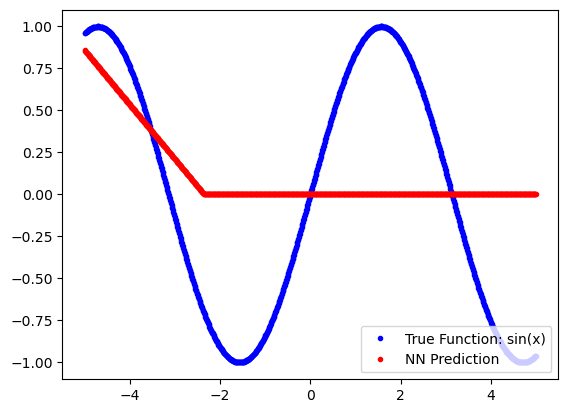

In [209]:
# Generate input data
x = torch.tensor(np.linspace(-5, 5, 1000), dtype=torch.float)
x = torch.unsqueeze(x, dim=1)
y = x.sin()

# Define the neural network
class Net1(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(1, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        
        return x

#def train_net1():         
    
# Initialize the network, optimizer, and loss function
net1 = Net1()
    
optimizer = optim.Adam(net1.parameters(), lr=0.001)
loss_func = nn.MSELoss()

# Training loop
for epoch in range(1000):
    y_hat = net1(x)
    loss = loss_func(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the results
    
plt.plot(x, y, 'b.', label='True Function: sin(x)')
plt.plot(x, (net1(x)).data.numpy(), 'r.', label='NN Prediction')
plt.legend()

plt.show()
       

# How do I load the model? 

# How do I do test case with the loaded model? 
net11 = Net1()



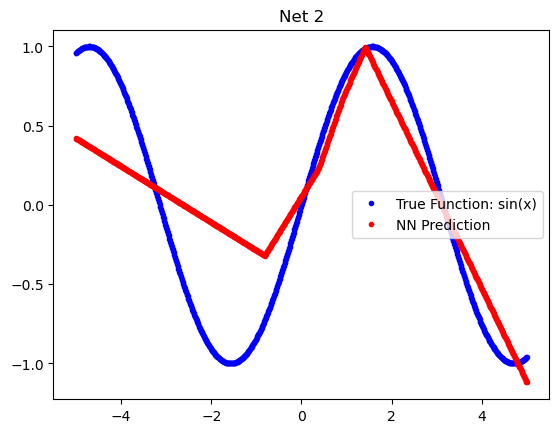

In [210]:
# Generate input data
x = torch.tensor(np.linspace(-5, 5, 1000), dtype=torch.float)
x = torch.unsqueeze(x, dim=1)

y = x.sin()

# Define the neural network
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 5)
        # self.fc2 = nn.Linear(5, 5)
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        # x = nn.functional.relu(self.fc2(x))
        x = self.fc2(x)
        return x

# Initialize the network, optimizer, and loss function
net2 = Net2()
optimizer = optim.Adam(net2.parameters(), lr=0.001)
loss_func = nn.MSELoss()

# Training loop
for epoch in range(1000):
    y_hat = net2(x)
    loss = loss_func(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the results
plt.title("Net 2")
plt.plot(x, y, 'b.', label='True Function: sin(x)')
plt.plot(x, net2(x).detach().numpy(), 'r.', label='NN Prediction')  # Detach here
plt.legend()
plt.show()

net21 = Net2()

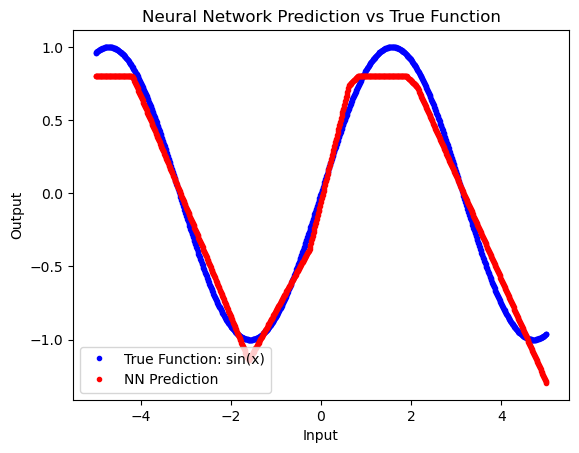

In [211]:
# Generate input data
x = torch.tensor(np.linspace(-5, 5, 1000), dtype=torch.float)
x = torch.unsqueeze(x, dim=1)

y = x.sin()
# Define the neural network
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the network, optimizer, and loss function
net3 = Net3()
optimizer = optim.Adam(net3.parameters(), lr=0.001)
loss_func = nn.MSELoss()

# Training loop
for epoch in range(1000):
    y_hat = net3(x)
    loss = loss_func(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the results
plt.plot(x, y.detach().numpy(), 'b.', label='True Function: sin(x)')  # Detach y for plotting
plt.plot(x, net3(x).detach().numpy(), 'r.', label='NN Prediction')  # Detach here
plt.legend()
plt.title("Neural Network Prediction vs True Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

net31 = Net3()

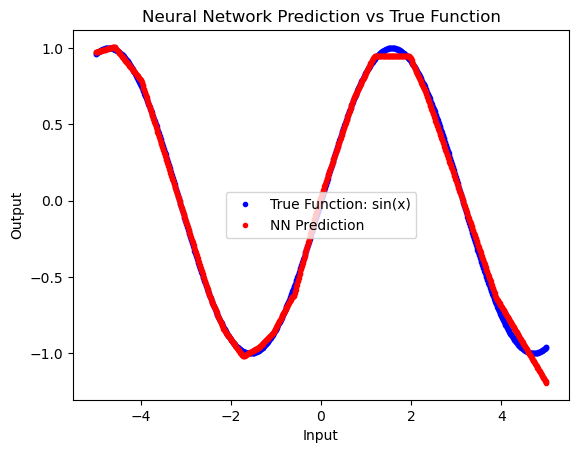

In [212]:
# Generate input data
x = torch.tensor(np.linspace(-5, 5, 1000), dtype=torch.float)
x = torch.unsqueeze(x, dim=1)

y = x.sin()
# Define the neural network
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 5)
        self.fc4 = nn.Linear(5, 1)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = self.fc4(x)  # Linear output without activation
        return x

# Initialize the network, optimizer, and loss function
net4 = Net4()
optimizer = optim.Adam(net4.parameters(), lr=0.001)
loss_func = nn.MSELoss()

# Training loop
for epoch in range(1000):
    y_hat = net4(x)
    loss = loss_func(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the results
plt.plot(x.detach().numpy(), y.detach().numpy(), 'b.', label='True Function: sin(x)')  # Detach y for plotting
plt.plot(x.detach().numpy(), net4(x).detach().numpy(), 'r.', label='NN Prediction')  # Detach here
plt.legend()
plt.title("Neural Network Prediction vs True Function")
plt.xlabel("Input")
plt.ylabel("Output")
plt.show()

net41 = Net4()

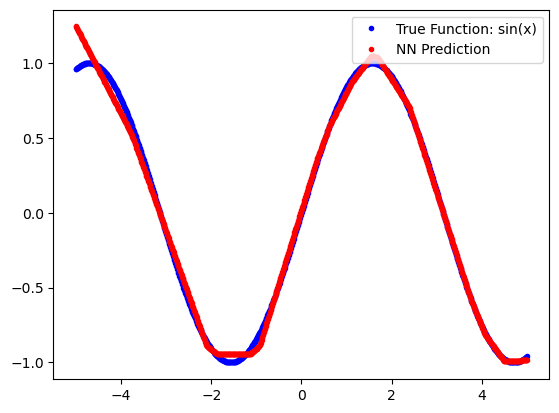

In [213]:
# Generate input data
x = torch.tensor(np.linspace(-5, 5, 1000), dtype=torch.float)
x = torch.unsqueeze(x, dim=1)

y = x.sin()


# Define the neural network
class Net5(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(1, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 5)
        self.fc4 = nn.Linear(5, 5)
        self.fc5 = nn.Linear(5, 1)
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = self.fc5(x)
        
        return x

#def train_net5():         
# Initialize the network, optimizer, and loss function
net5 = Net5()
optimizer = optim.Adam(net5.parameters(), lr=0.001)
loss_func = nn.MSELoss()

# Training loop
for epoch in range(1000):
    y_hat = net5(x)
    loss = loss_func(y_hat, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Plot the results
plt.plot(x, y, 'b.', label='True Function: sin(x)')
plt.plot(x, (net5(x)).data.numpy(), 'r.', label='NN Prediction')
plt.legend()

plt.show()

net51 = Net5()

In [214]:
"""
Train and generate samples 
"""

save_sample_and_model(1, net1, x, y)


---- model passed
Net1(
  (fc1): Linear(in_features=1, out_features=1, bias=True)
)
-----------------
---- data_path :  data/samples_model_01.csv
Saved 20  random samples of x and sin(x) to : data/samples_model_01.csv
pth model path :  model/pth/model_01.pth
---- onnx_model_path :  model/onnx/model_01.onnx
Saved onnx file :  model/onnx/model_01.onnx


In [215]:
save_sample_and_model(2, net2, x, y)


---- model passed
Net2(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)
-----------------
---- data_path :  data/samples_model_02.csv
Saved 20  random samples of x and sin(x) to : data/samples_model_02.csv
pth model path :  model/pth/model_02.pth
---- onnx_model_path :  model/onnx/model_02.onnx
Saved onnx file :  model/onnx/model_02.onnx


In [216]:
save_sample_and_model(3, net3, x, y)
save_sample_and_model(4, net4, x, y)
save_sample_and_model(5, net5, x, y) 

---- model passed
Net3(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)
-----------------
---- data_path :  data/samples_model_03.csv
Saved 20  random samples of x and sin(x) to : data/samples_model_03.csv
pth model path :  model/pth/model_03.pth
---- onnx_model_path :  model/onnx/model_03.onnx
Saved onnx file :  model/onnx/model_03.onnx
---- model passed
Net4(
  (fc1): Linear(in_features=1, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)
-----------------
---- data_path :  data/samples_model_04.csv
Saved 20  random samples of x and sin(x) to : data/samples_model_04.csv
pth model path :  model/pth/model_04.pth
---- onnx_model_path :  model/onnx/model_04.onnx
Saved onnx file :  model/onnx/model_04.onnx
---- m

In [217]:
"""
Test and save results
"""
load_model_and_save_result(1, net11)


modelPath :  model/pth/model_01.pth
<class 'numpy.ndarray'>
---- reading sampled test data from file :  data/samples_model_01.csv
Row 0: -2.7277276515960693
Net output: 0.12134861946105957
------
Row 1: -1.976976990699768
Net output: 0.0
------
Row 2: -2.6376376152038574
Net output: 0.09217816591262817
------
Row 3: 4.759759902954102
Net output: 0.0
------
Row 4: -0.12512512505054474
Net output: 0.0
------
Row 5: -4.309309482574463
Net output: 0.6334527134895325
------
Row 6: -4.389389514923096
Net output: 0.6593820452690125
------
Row 7: -4.77977991104126
Net output: 0.7857875227928162
------
Row 8: -4.619619846343994
Net output: 0.7339288592338562
------
Row 9: -0.7057057023048401
Net output: 0.0
------
Row 10: 1.1261261701583862
Net output: 0.0
------
Row 11: -3.748748779296875
Net output: 0.45194751024246216
------
Row 12: 4.989989757537842
Net output: 0.0
------
Row 13: -1.2562562227249146
Net output: 0.0
------
Row 14: -3.6886887550354004
Net output: 0.43250054121017456
------
Ro

In [218]:
load_model_and_save_result(2, net21)


modelPath :  model/pth/model_02.pth
<class 'numpy.ndarray'>
---- reading sampled test data from file :  data/samples_model_01.csv
Row 0: -2.7277276515960693
Net output: 0.019096672534942627
------
Row 1: -1.976976990699768
Net output: -0.113718181848526
------
Row 2: -2.6376376152038574
Net output: 0.003158867359161377
------
Row 3: 4.759759902954102
Net output: -0.9780911207199097
------
Row 4: -0.12512512505054474
Net output: -0.00168532133102417
------
Row 5: -4.309309482574463
Net output: 0.2988934814929962
------
Row 6: -4.389389514923096
Net output: 0.31306031346321106
------
Row 7: -4.77977991104126
Net output: 0.3821242153644562
------
Row 8: -4.619619846343994
Net output: 0.35379037261009216
------
Row 9: -0.7057057023048401
Net output: -0.26905351877212524
------
Row 10: 1.1261261701583862
Net output: 0.8109884262084961
------
Row 11: -3.748748779296875
Net output: 0.19972500205039978
------
Row 12: 4.989989757537842
Net output: -1.1140962839126587
------
Row 13: -1.256256222

In [219]:
load_model_and_save_result(3, net31)


modelPath :  model/pth/model_03.pth
<class 'numpy.ndarray'>
---- reading sampled test data from file :  data/samples_model_01.csv
Row 0: -2.7277276515960693
Net output: -0.29474306106567383
------
Row 1: -1.976976990699768
Net output: -0.8611730337142944
------
Row 2: -2.6376376152038574
Net output: -0.36271440982818604
------
Row 3: 4.759759902954102
Net output: -1.1259883642196655
------
Row 4: -0.12512512505054474
Net output: -0.2128915786743164
------
Row 5: -4.309309482574463
Net output: 0.803246021270752
------
Row 6: -4.389389514923096
Net output: 0.803246021270752
------
Row 7: -4.77977991104126
Net output: 0.803246021270752
------
Row 8: -4.619619846343994
Net output: 0.803246021270752
------
Row 9: -0.7057057023048401
Net output: -0.6355510950088501
------
Row 10: 1.1261261701583862
Net output: 0.803246021270752
------
Row 11: -3.748748779296875
Net output: 0.4756019115447998
------
Row 12: 4.989989757537842
Net output: -1.2883613109588623
------
Row 13: -1.2562562227249146
N

In [220]:
load_model_and_save_result(4, net41)


modelPath :  model/pth/model_04.pth
<class 'numpy.ndarray'>
---- reading sampled test data from file :  data/samples_model_01.csv
Row 0: -2.7277276515960693
Net output: -0.3863258361816406
------
Row 1: -1.976976990699768
Net output: -0.9188283085823059
------
Row 2: -2.6376376152038574
Net output: -0.4701603055000305
------
Row 3: 4.759759902954102
Net output: -1.074212670326233
------
Row 4: -0.12512512505054474
Net output: -0.09589849412441254
------
Row 5: -4.309309482574463
Net output: 0.9063632488250732
------
Row 6: -4.389389514923096
Net output: 0.93610680103302
------
Row 7: -4.77977991104126
Net output: 0.990511953830719
------
Row 8: -4.619619846343994
Net output: 1.0042014122009277
------
Row 9: -0.7057057023048401
Net output: -0.6658962368965149
------
Row 10: 1.1261261701583862
Net output: 0.9170011281967163
------
Row 11: -3.748748779296875
Net output: 0.5637996196746826
------
Row 12: 4.989989757537842
Net output: -1.189522624015808
------
Row 13: -1.2562562227249146
Ne

In [221]:
load_model_and_save_result(5, net51)


modelPath :  model/pth/model_05.pth
<class 'numpy.ndarray'>
---- reading sampled test data from file :  data/samples_model_01.csv
Row 0: -2.7277276515960693
Net output: -0.35825759172439575
------
Row 1: -1.976976990699768
Net output: -0.9192734360694885
------
Row 2: -2.6376376152038574
Net output: -0.4349285364151001
------
Row 3: 4.759759902954102
Net output: -0.988785982131958
------
Row 4: -0.12512512505054474
Net output: -0.10199490189552307
------
Row 5: -4.309309482574463
Net output: 0.8412810564041138
------
Row 6: -4.389389514923096
Net output: 0.8879755735397339
------
Row 7: -4.77977991104126
Net output: 1.1156103610992432
------
Row 8: -4.619619846343994
Net output: 1.0222218036651611
------
Row 9: -0.7057057023048401
Net output: -0.6705484986305237
------
Row 10: 1.1261261701583862
Net output: 0.8769710063934326
------
Row 11: -3.748748779296875
Net output: 0.5056886672973633
------
Row 12: 4.989989757537842
Net output: -0.9848794937133789
------
Row 13: -1.25625622272491